In [7]:
import numpy as np
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch

from Testing import Test
from Blackjack.Environment import BJEnvironment
import matplotlib.pyplot as plt

VERSION = 11
COMPLETEDVERSION = 1
EPOCH = 2

In [8]:
def get_obs(player_sum, dealer_card, usable_ace):
    # player_sum, dealer_sum, usable_ace, split_pos, double_pos, prob_21, game_state
    has_double = True
    prob_21 = int((100*(21-player_sum)/21)/10)
    game_state = 0
    has_split = player_sum % 2 == 0 and player_sum > 2
    state = np.array(
        [
            player_sum,
            dealer_card,
            usable_ace,
            has_split,
            has_double,
            prob_21,
            game_state,
        ]
    )
    state = state.astype(np.uint8)
    state = np.reshape(state, [1, 7])
    return state


def create_grid(model, usable_ace = False):
    policy = defaultdict(int)

    for cardP in range(4,22):
        for cardD in range(1,11):
            obs = get_obs(cardP, cardD, usable_ace)
            obs = np.reshape(obs, [1, 7])
            policy[(cardP, cardD, usable_ace)] = model.predict(obs)

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(4, 22),
        np.arange(1, 11),
    )

    """
    valueHS = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis = 2,
        arr=np.dstack([player_count, dealer_count])
    )
    valueHS_grid = player_count, dealer_count, valueHS

    valueSD = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    
    valueSD_grid = player_count, dealer_count, valueSD   
    """
    policy_grid = np.apply_along_axis(
        lambda obs: np.argmax(policy[(obs[0], obs[1], usable_ace)]),
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return policy_grid
    """
    return policy_grid, valueHS_grid, valueSD_grid
    """
def create_plots(policy_grid, title:str):
    """"
    player_count, dealer_count, valueHS = valueHS_grid
    player_count, dealer_count, valueSD = valueSD_grid
    """
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)
    """ 
    ax1 = fig.add_subplot(1,2,1,projection ="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        valueHS,
        rstride = 1,
        cstride = 1,
        cmap = "viridis",
        edgecolor = "none"
    )

    plt.xticks(range(12,22), range(12,22))
    plt.yticks(range(1,11) + list(range(1,11)))
    ax1.set_title(f"State values, Hit & Stand: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20,200)

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax2.plot_surface(
        player_count,
        dealer_count,
        valueSD,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )

    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11) + list(range(1, 11)))
    ax2.set_title(f"State values, Hit & Stand: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_zlabel("Value", fontsize=14, rotation=90)
    ax2.view_init(20, 200)
    """
    
    fig.add_subplot(1,2,1)
    ax3 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax3.set_title(f"Policy: {title}")
    ax3.set_xlabel("Player sum")
    ax3.set_ylabel("Dealer showing")
    ax3.set_xticklabels(range(4,22))
    ax3.set_yticklabels(list(range(1,11)),fontsize=12)

    legend_elements = [
        Patch(facecolor="black", edgecolor="black", label="Hit"),
        Patch(facecolor="yellow", edgecolor="black", label="Stand"),
        Patch(facecolor="orange", edgecolor="black", label="Split"),
        Patch(facecolor="green", edgecolor="black", label="Double")
    ]
    ax3.legend(handles=legend_elements,bbox_to_anchor=(1.3,1))
    return fig

In [9]:
env = BJEnvironment()
test = Test()

test.ModelClass.loadCheckpoint(VERSION, COMPLETEDVERSION, EPOCH)
#test.ModelClass.loadModel(VERSION, COMPLETEDVERSION)

print(test.ModelClass.model.get_weights())
obs = env.observation_space.sample()
obs = np.reshape(obs, [1, env.state_size])
print(obs)
print(test.ModelClass.model.predict(obs))

test.ModelClass.predict(obs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1024      
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1540 (6.02 KB)
Trainable params: 1540 (6.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
[array([[-1.45614058e-01, -1.75267502e-04, -1.20906159e-01,
        -2.86500633e-01, -1.17158897e-01, -4.10219938e-01,
         8.53201002e-03, -9.07063559e-02, -3.17604303e-01,
        -2.41161212e-01, -4.46196765e-01,  1.85815617e-02,
        -1.95990160e-01, -1.28738582e-03, -6.26959428e-02,
        -2.35336274e-01, -4.28851664e-01, -2.94772208e-01,
        -1.79488778e-01, -1.72889069e-01, -3.95575851e-01,
    

1

In [10]:
policy_grids_na = create_grid(test.ModelClass.model, False)
policy_grids = create_grid(test.ModelClass.model, True)

1/1 [==============================] - 0s 18ms/step


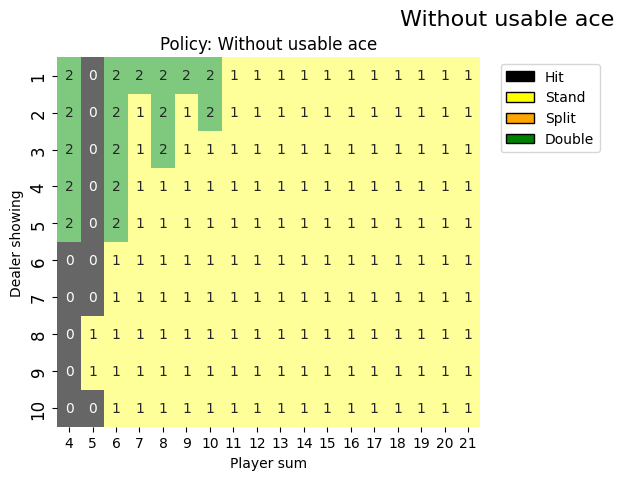

In [11]:
fig1 = create_plots(policy_grids_na, title="Without usable ace")

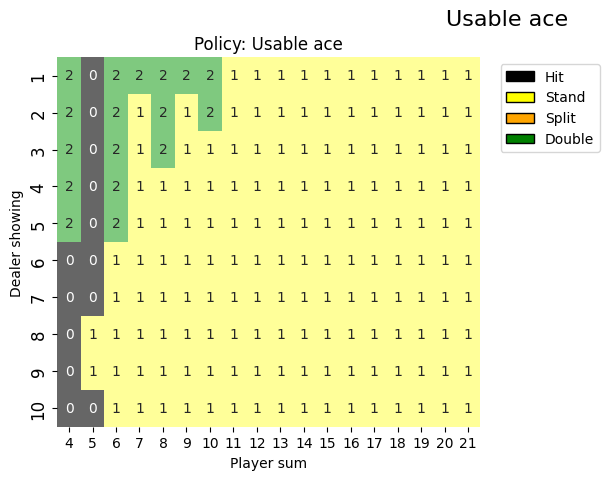

In [12]:
fig2 = create_plots(policy_grids, title="Usable ace")